<a href="https://colab.research.google.com/github/huili8905/cs5242_project/blob/Hui-Li/RNN%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---


# **Set-up for Google Drive**

---

1.   Load Libraries
2.   Check GPU Setting
3.   Mount Google Drive
4.   Load Dataset

In [0]:
#################################################
#Crash the original RAM to increase to 25GB - if required
#################################################
a = []
while(1):
    a.append("1")

In [0]:
######################
1. #Maintain libraries
######################
#utils
from google.colab import drive,files
import tarfile

#wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os

#pytorch library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader, Dataset

#keras library
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,TimeDistributed,LSTM,Masking, Dropout
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
tf.__version__

'1.15.0'

In [0]:
######################
2. #Check GPU Setting
######################
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cpu')

In [0]:
######################
3. #Mount Google Drive
######################
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
######################
4. #Load Dataset
######################
#Check default location
os.getcwd()

'/content'

In [0]:
#Update your path to your dataset
os.chdir('/gdrive/My Drive/')

In [0]:
#Read read_datasetBreakfast.py from the folder location

from read_datasetBreakfast import load_data, read_mapping_dict , get_label_length_seq
COMP_PATH = '/gdrive/My Drive/'
''' 
training to load train set
test to load test set
'''
mapping_loc =  os.path.join(COMP_PATH, 'splits/mapping_bf.txt') 
actions_dict = read_mapping_dict(mapping_loc)
GT_folder   =  os.path.join(COMP_PATH, 'groundTruth/') #Ground Truth Labels for each training video 
DATA_folder =  os.path.join(COMP_PATH, 'data/') #Frame I3D features for all videos


for split in ['training','test']:
  if  split == 'training':
    train_split =  os.path.join(COMP_PATH, 'splits/train.split1.bundle') #Train Split
    data_feat_train, data_labels = load_data(train_split, actions_dict, GT_folder, DATA_folder, datatype = split) #Get features and labels
  if  split == 'test':
    test_split  =  os.path.join(COMP_PATH, 'splits/test.split1.bundle') #Test Split
    data_feat_test = load_data(test_split, actions_dict, GT_folder, DATA_folder, datatype = split)

---

# **Data Preparation and Exploration**

---

1.   Check Data Shape
2.   How Much Data
3.   No. of Classes
4.   Class Distribution (BY VIDEO)
5.   Class Distribution (BY FRAME)
6.   Get Tensor Data and Labels Ready

In [0]:
######################
1. #Check Data Shape
######################

print("data shape: {} and date type: {}".format(data_feat_train[0].shape,data_feat_train[0].dtype))
print("data shape: {} and date type: {}".format(data_feat_train[1].shape,data_feat_train[0].dtype))

data shape: torch.Size([544, 400]) and date type: torch.float64
data shape: torch.Size([6932, 400]) and date type: torch.float64


In [0]:
######################
2. #How Much Data
######################
print("Number of Training Data: {}".format(len(data_feat_train)))
print("Number of Training Data Labels: {}".format(len(data_labels)))
print("Number of Test Data: {}".format(len(data_feat_test)))
print("% of Test Data: {}".format(len(data_feat_test)/(len(data_feat_train)+len(data_feat_test))*100))


Number of Training Data: 1460
Number of Training Data Labels: 1460
Number of Test Data: 252
% of Test Data: 14.719626168224298


In [0]:
##Unique Labels in each video
print("Unique Labels in video 0: {} ".format(data_labels[0]))
print("Frames in video 0: {} ".format(len(data_feat_train[0])))

Unique Labels in video 0: [1, 2] 
Frames in video 0: 544 


In [0]:
######################
3. #No. of class
###################### 
len(actions_dict)

48

In [0]:
######################
4. #Class Distribution (BY VIDEO)
######################
def wrangle_class_distribution(data_label_var , actions_dict):
  #check for labels class balance
  data_label_var = pd.DataFrame(data_label_var)
  data_label_var = pd.DataFrame(data_label_var.unstack(level=0)).reset_index()
  data_label_var.drop('level_0',inplace=True,axis=1)
  data_label_var.dropna(inplace=True)
  data_label_var.columns =['sample_no','cat']
  data_label_var['cat'].astype(int)
  
  #mapping for actions (change keys and values)
  actions_dict2 = {y:x for x,y in actions_dict.items()}
  data_label_var['cat_name'] = data_label_var['cat'].map(actions_dict2)

  return data_label_var

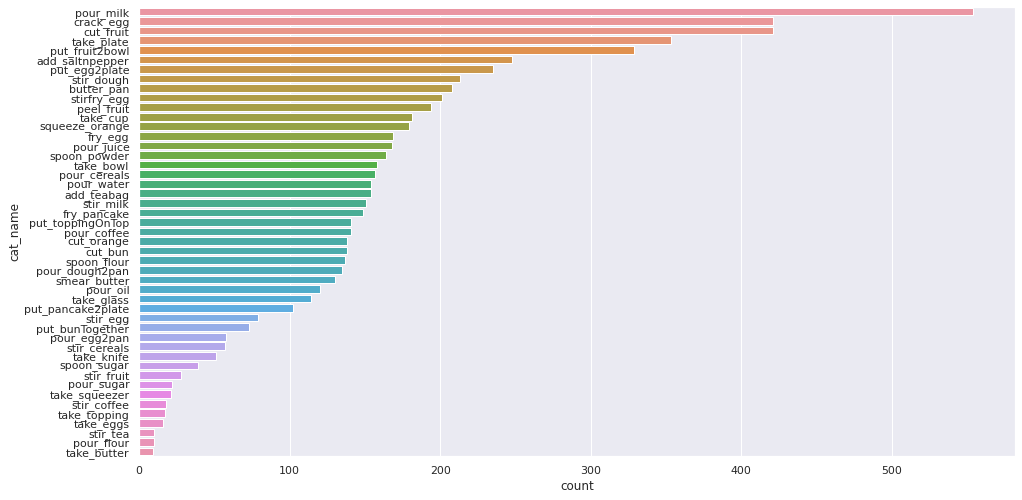

In [0]:
%matplotlib inline
sn.set(rc={'figure.figsize':(15.7,8.27)})
Train_Class_Dis = wrangle_class_distribution(data_labels , actions_dict)

sn.countplot(y= 'cat_name',orient= 'h',data=Train_Class_Dis,order = Train_Class_Dis['cat_name'].value_counts().index)
plt.show()

#note: no. of unique labels per label in each video

In [0]:
######################
5. #Class Distribution (BY FRAME)
######################
def get_frame_breakdown(COMP_PATH):
  gt_frame_overall = pd.DataFrame()
  for filesname in os.listdir(COMP_PATH+'/groundTruth'):
    gt_file_level = pd.read_csv(COMP_PATH+'/groundTruth/'+filesname,header=None)
    gt_file_level['file_name'] = filesname
    gt_file_level.columns=['cat_name','file_name']
    
    gt_file_level['cat_no'] = gt_file_level['cat_name'].map(actions_dict)
    gt_frame_overall = pd.concat([gt_frame_overall,gt_file_level], sort=False) 

  return gt_frame_overall

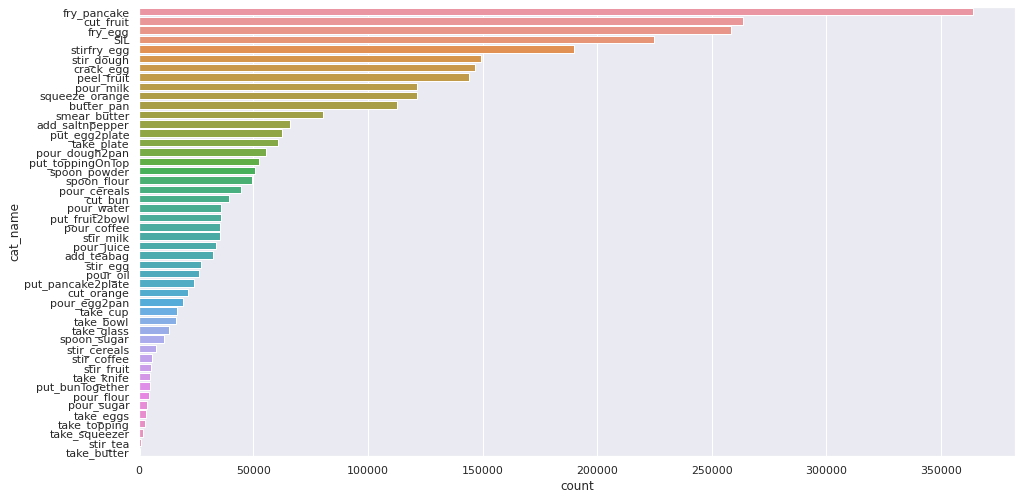

In [0]:
COMP_PATH = '/gdrive/My Drive/'
gt_frame_overall = get_frame_breakdown(COMP_PATH)

%matplotlib inline
sn.set(rc={'figure.figsize':(15.7,8.27)})

sn.countplot(y= 'cat_name',orient= 'h',data=gt_frame_overall,order = gt_frame_overall['cat_name'].value_counts().index)
plt.show()

In [0]:
######################
6. #Get Tensor Data and Labels Ready
######################
#get the labels of each frame
def get_gt(train_split):
   file_ptr = open(train_split, 'r')
   content_all = file_ptr.read().split('\n')[1:-1]
   content_all = [x.strip('./data/groundTruth/') + 't' for x in content_all]
   all_tasks = ['tea', 'cereals', 'coffee', 'friedegg', 'juice', 'milk', 'sandwich', 'scrambledegg', 'pancake', 'salat']
   
   labelframe_breakfast = []
   labelseq_breakfast = []
   labellen_breakfast = []

   for content in content_all:
     file_ptr = open( GT_folder + content, 'r')
     curr_gt = file_ptr.read().split('\n')[:-1]
     curr_gt = list(map(actions_dict.get, curr_gt))

     labelframe_breakfast.append(curr_gt)     
     #label_seq, length_seq = get_label_length_seq(curr_gt)
     #labelseq_breakfast.append(label_seq)  
     #labellen_breakfast.append(length_seq)  

   return labelframe_breakfast

labelframe_breakfast = get_gt(train_split)

print("data label len: {} ".format(len(labelframe_breakfast)))
print("Video 0 data label len: {} ".format(len(labelframe_breakfast[0])))

data label len: 1460 
Video 0 data label len: 544 


In [0]:
#Split the dataset into train_val dataset (not required)
#from sklearn.model_selection import train_test_split
#train_data ,val_data, train_label,val_label = train_test_split(data_feat_train ,labelframe_breakfast , random_state=123, test_size=0.2)

#print("train data label len: {} ".format(len(train_data)))
#print("val data label len: {} ".format(len(val_data)))

train data label len: 1168 
val data label len: 292 


---

# **LSTM / GRU Model**


---

In [0]:
def batch_generator(data_feat_train ,labelframe_breakfast,batch_size,iteration_no):
  start_idx = batch_size*iteration_no
  end_idx = batch_size* (iteration_no +1) 

  X = data_feat_train [start_idx : end_idx]
  y = labelframe_breakfast [start_idx : end_idx]

  X = sequence.pad_sequences(X,dtype='float64', value=0.0)
  y = sequence.pad_sequences(y)

  return X, y

In [0]:
#Define LSTM parameters
n_batch = 73
n_batch_size = 16
epoch = 64


In [0]:
for i in range(n_batch):
  # padded seqeunces
  X,y = batch_generator(data_feat_train ,labelframe_breakfast,n_batch_size,i) 
  length = X.shape[1]
  y = np.reshape(y, (32,length,1))

  # define LSTM configuration
  n_neurons = length
  n_batch_size = 16
  n_epoch = 100
  # create LSTM
  model = Sequential()
  model.add(Masking(mask_value=0., input_shape=(None, 400)))
  model.add(LSTM(n_neurons, input_shape=(None, 400), return_sequences=True))
  model.add(LSTM(n_neurons, return_sequences=True))
  model.add(TimeDistributed(Dense(48, activation="softmax")))

  sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9)
  model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['categorical_accuracy'])
  print(model.summary())
  # train LSTM
  model.fit(X, y, epochs=n_epoch, batch_size=n_batch)
  model.reset_states()
  # evaluate
  result = model.predict(X, batch_size=n_batch, verbose=0)

  for value in result[0,:,0]:
    print('%.1f' % value)

# Archive

In [0]:
#Set the variables
input_dim = 400
hidden_dim = 100
n_layers = 2
output_dim = 48

batch_size = 1  
n_iters = 3000
num_epochs = n_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

In [0]:
class RNNLSTM_test(nn.Module):
  def __init__(self,input_dim,hidden_dim,output_dim,n_layers, drop_prob=0.5):
    super(RNNLSTM_test, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.n_layers = n_layers

    self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first =True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self,x):
    # Initialize hidden state with zeros
    h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_()

    # Initialize cell state
    c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_()

    # Set Variable time steps
    # We need to detach as we are doing truncated backpropagation through time (BPTT)
    # If we don't, we'll backprop all the way to the start even after going through another batch
    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

    # Index hidden state of last time step
    out = self.fc(out[:, -1, :]) 
    #out = [self.fc[i](out[:, i, :]) for i in range(seq_dim)]

    return out

In [0]:
#init the models and optimizers
model =  RNNLSTM_test(input_dim, hidden_dim, n_layers, output_dim)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

iter = 0
for epoch in range(1):
  for i in range(len(train_data[0:3])):
    seq_dim = len(train_data[i])
    images = train_data[i]
    labels = train_label[i]
    # Reshape Images to 3D
    images = images.view(-1, seq_dim, input_dim)
    images = images.view(-1, seq_dim, input_dim).requires_grad_()

    # Change Labels to tensor and reshape
    labels = torch.FloatTensor(labels)
    labels = labels.view(-1,len(train_label[i]),1)

    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()

    # Forward pass to get output/logits
    outputs = model(images.float())

  # Calculate Loss: softmax --> cross entropy loss
    loss = criterion(outputs, labels)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()

    iter += 1

    if iter % 500 == 0:
        # Calculate Accuracy         
        correct = 0
        total = 0
        # Iterate through test dataset
        for images, labels in test_loader:
            # Resize image
            images = images.view(-1, seq_dim, input_dim)

            # Forward pass only to get logits/output
            outputs = model(images)

            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)

            # Total number of labels
            total += labels.size(0)

            # Total correct predictions
            correct += (predicted == labels).sum()

        accuracy = 100 * correct / total

        # Print Loss
        print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy)) 